# Exploratory Data Analysis (EDA) and Pattern Discovery
In this notebook, we explore patterns in the cleaned cyberbullying tweets dataset.
The goal is to understand the text data better and extract insights that could help in modeling.


In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import nltk
from wordcloud import STOPWORDS
import itertools
from textblob import TextBlob

nltk.download('stopwords')

df = pd.read_csv("clean_tweets.csv")
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,not_cyberbullying
1,why is aussietv so white? mkr theblock imacele...,not_cyberbullying
2,a classy whore? or more red velvet cupcakes?,not_cyberbullying
3,meh. p thanks for the heads up but not too con...,not_cyberbullying
4,this is an isis account pretending to be a kur...,not_cyberbullying


## 1. Bar chart of class distribution

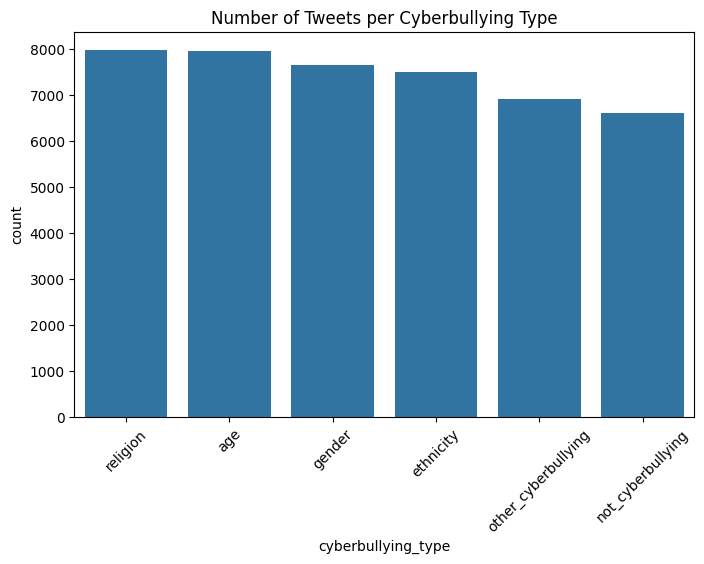

In [3]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='cyberbullying_type', order=df['cyberbullying_type'].value_counts().index)
plt.title("Number of Tweets per Cyberbullying Type")
plt.xticks(rotation=45)
plt.show()

## 2. Vocabulary Insights
We check the most frequent words in each label.  
This gives us an idea of what kind of language is used in different hate categories.  
We use TF-IDF to find the most important words in each type of hate and visualize the top words in a horizontal bar chart.
TF-IDF is a way to measure how important a word is in a text compared to all other texts, giving higher scores to words that appear often in one text but not in others.


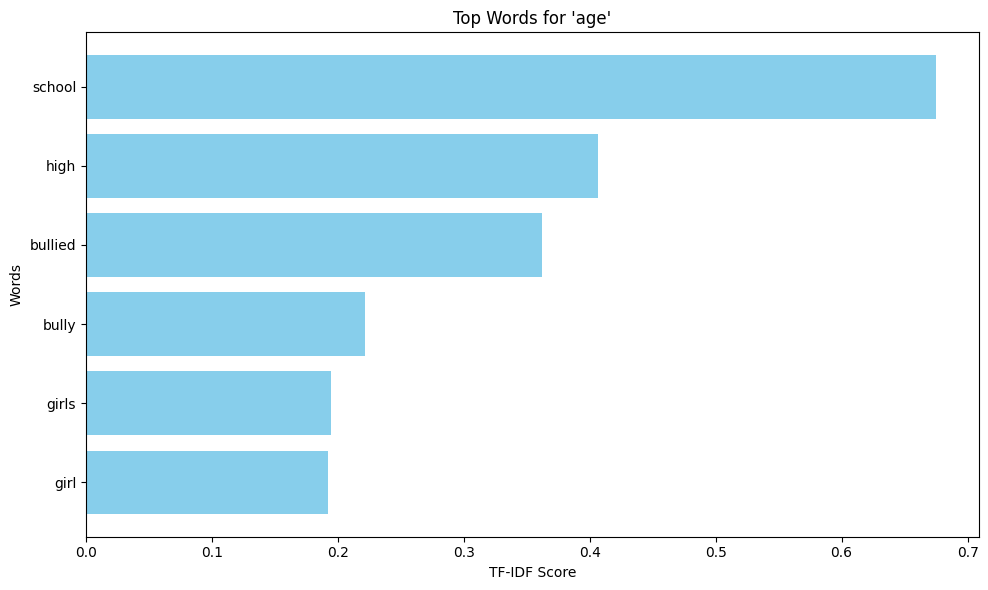

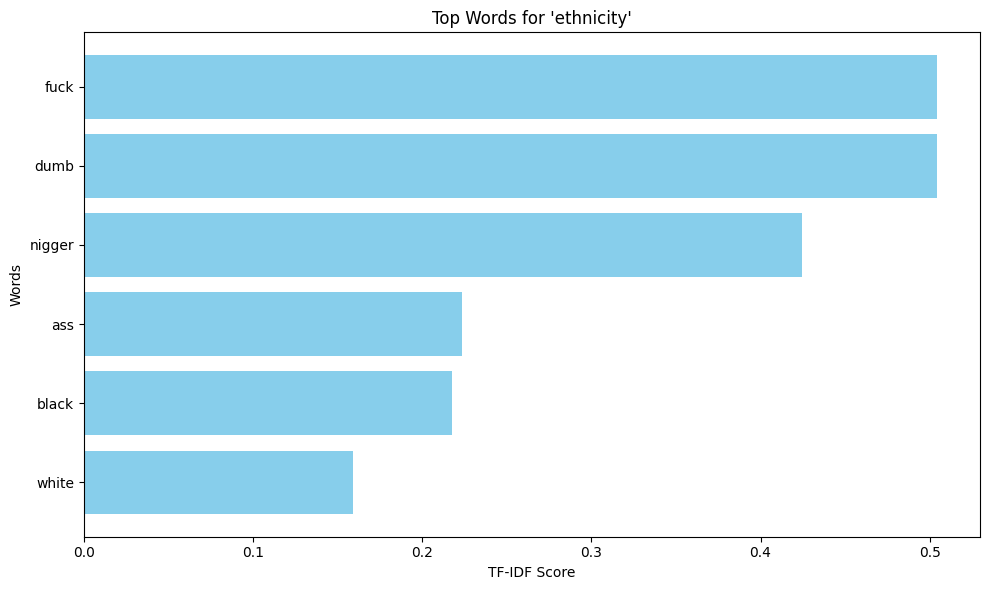

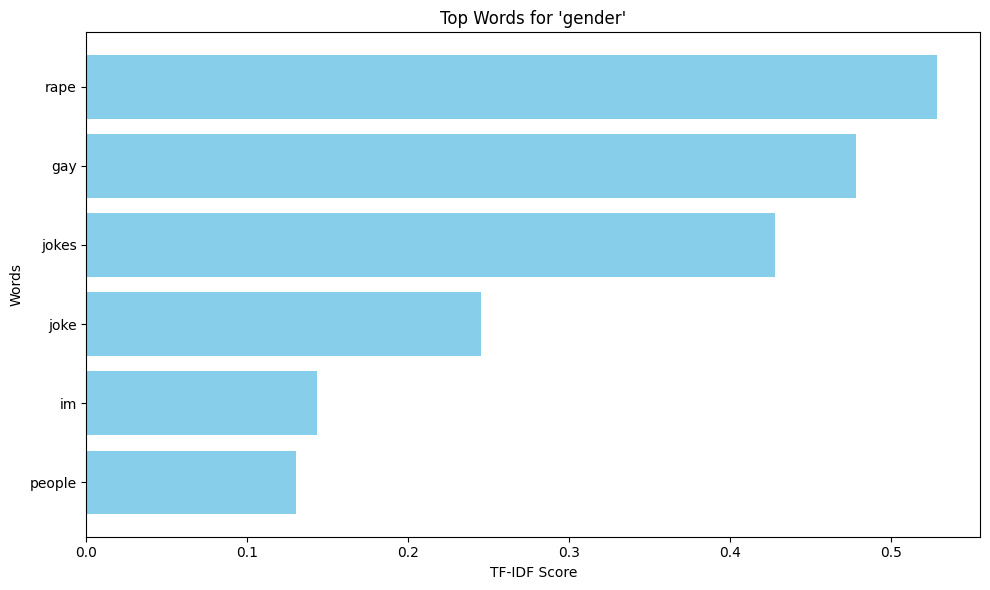

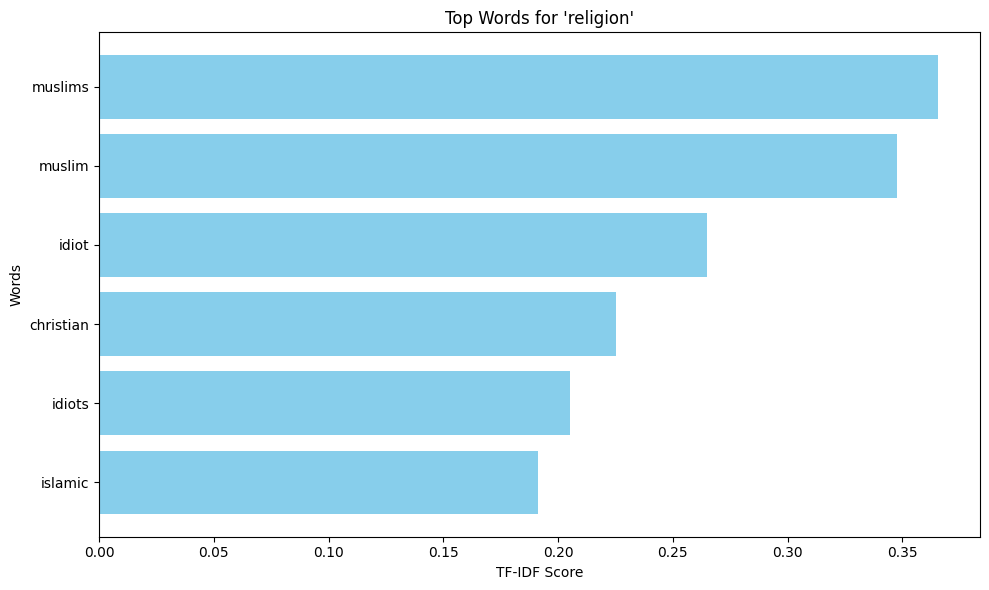

In [21]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# fiter types
categories = ['religion', 'gender', 'ethnicity','age']
df_filtered = df[df['cyberbullying_type'].isin(categories)]
grouped_texts = df_filtered.groupby('cyberbullying_type')['tweet_text']\
    .apply(lambda x: ' '.join(x.astype(str)))

# create a bar chart for each category
for category, text_corpus in grouped_texts.items():
    tfidf_matrix = vectorizer.fit_transform([text_corpus])
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.toarray().flatten()

    # get top 6 words
    df_tfidf = pd.DataFrame({'word': feature_names, 'tfidf': scores})
    top_words = df_tfidf.sort_values(by='tfidf', ascending=False).head(6)

    plt.figure(figsize=(10,6))
    plt.barh(top_words['word'][::-1], top_words['tfidf'][::-1], color='skyblue')
    plt.title(f"Top Words for '{category}'")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()


## 3. TF-IDF Similarity Between Cyberbullying Types
Here, we want to see how similar the categories are in terms of the words they use. We combine all tweets for each category, compute their TF-IDF representations, and then calculate the cosine similarity between them. Higher values mean the categories share more common vocabulary.

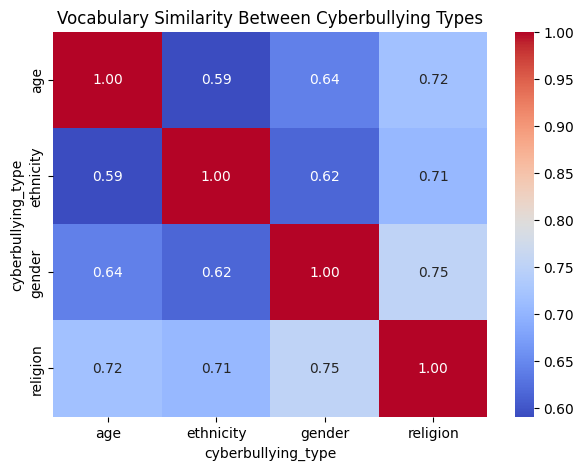

In [27]:
categories = ['religion', 'gender', 'ethnicity','age']
df_filtered = df[df['cyberbullying_type'].isin(categories)]
grouped = df_filtered.groupby("cyberbullying_type")["tweet_text"].apply(lambda x: " ".join(x.astype(str)))

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(grouped)

# cosine similarity
similarity = cosine_similarity(tfidf_matrix)

sim_df = pd.DataFrame(similarity, index=grouped.index, columns=grouped.index)

plt.figure(figsize=(7,5))
sns.heatmap(sim_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Vocabulary Similarity Between Cyberbullying Types")
plt.show()


What we can notice from the heatmap:

- A strong similarity between age and cyberbullying type (0.59).
- A notable similarity between gender and religion (0.75).
- The least similarity between age and religion (-1.0), indicating distinct vocabularies.

## 4. Word Co-occurrence (Bigrams)

We also look at the most common word pairs (bigrams).  
This helps us see which phrases appear together often in each type of cyberbullying.  


In [32]:
def get_top_bigrams(texts, n=10):
    texts = texts.dropna().astype(str)
    vec = CountVectorizer(ngram_range=(2,2), stop_words="english").fit(texts)
    bag = vec.transform(texts)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

for c in categories:
    top_ngrams = get_top_bigrams(df[df['cyberbullying_type']==c]['tweet_text'], n=5)
    top_words_only = [word for word, count in top_ngrams]  # keep only the words
    print(f"\nType: {c}")
    print(top_words_only)


Type: religion
['islamic terrorism', 'christian woman', 'radical islamic', 'idiots like', 'support radical']

Type: gender
['rape jokes', 'rape joke', 'gay jokes', 'im sexist', 'gay rape']

Type: ethnicity
['dumb ass', 'ass nigger', 'fuck obama', 'obama dumb', 'dumb nigger']

Type: age
['high school', 'bullied high', 'girls bullied', 'school bully', 'girl bullied']


## 5. Sentiment Analysis
We use sentiment polarity (from -1 negative to +1 positive).  
This shows whether tweets in each category are generally more negative or neutral.  

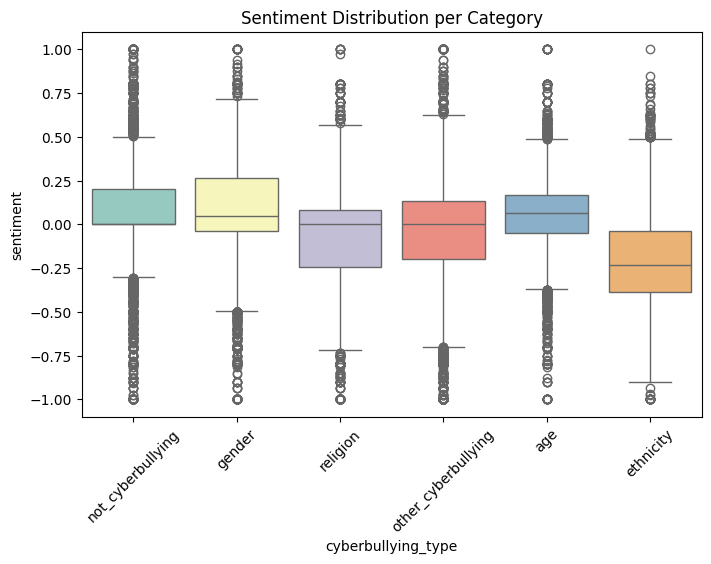

In [35]:
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df["sentiment"] = df["tweet_text"].apply(get_sentiment)

plt.figure(figsize=(8,5))
sns.boxplot(x="cyberbullying_type", y="sentiment", hue="cyberbullying_type", data=df, palette="Set3", dodge=False)
plt.xticks(rotation=45)
plt.title("Sentiment Distribution per Category")
plt.legend([],[], frameon=False)  # hides duplicate legend
plt.show()

The boxplot shows the sentiment distribution per category. Key observations include:
- "not cyberbullying" has a positive sentiment centered around 0.25, indicating generally positive or neutral content.
- "gender" and "religion" show neutral to slightly negative sentiments, with medians near 0.
- "other cyberbullying" has a negative sentiment, with a median around -0.25, suggesting more negative content.
- "age" and "ethnicity" also lean negative, with medians around -0.25 to 0, indicating a tendency toward negative sentiment in these categories.

# Conclusion

In this notebook, we:
- Looked at the label distribution  
- Explored the most frequent words  
- Compared cyberbullying types using TF-IDF similarity  
- Checked common word pairs (bigrams)  
- Analyzed sentiment per category  

These findings give us a better understanding of the dataset and the patterns inside it.  
They will also guide us later when we train the models.  
